**Восстановление смеси плотностей распределений.**

алгоритм EM с последовательным добавлением компонент смеси  

Евгений Борисов borisov.e@solarl.ru

---

## библиотеки

In [1]:
from time import time

import numpy as np
import matplotlib.pyplot as plt

# from sklearn.preprocessing import MinMaxScaler
# from sklearn.model_selection import train_test_split

##  загружаем данные 

In [2]:
X = np.loadtxt('../data/400_1/points_9.txt')

### рисуем данные


In [3]:
plot_frame = np.vstack([ X.min(axis=0)-0.5,X.max(axis=0)+0.5 ])
plot_frame

array([[ 1.64584936,  0.4766026 ],
       [10.09105573,  7.32364133]])

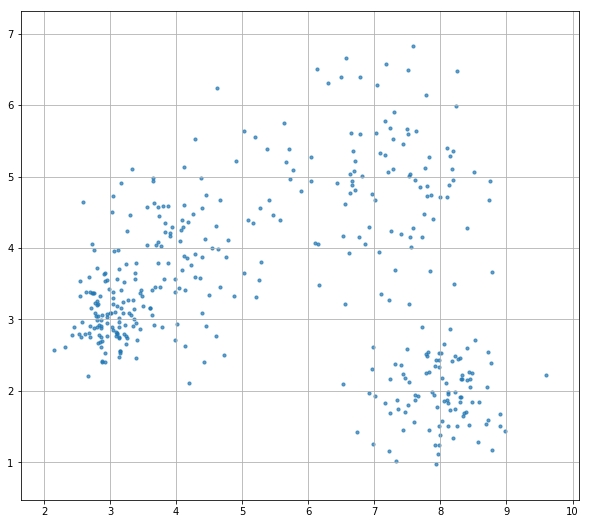

In [4]:
plt.gcf().set_size_inches(10,9)
plt.xlim(plot_frame[:,0])
plt.ylim(plot_frame[:,1])

plt.scatter( X[:,0], X[:,1],s=10,alpha=0.7)
plt.grid()
plt.show()

## инициализация параметров

In [5]:
# def get_seed(): t = time() ; return int(((t%1)/(t//1))*1e11)

In [6]:
# инициализация генератора псевдослучайных чисел
# np.random.seed( seed=get_seed() )

In [7]:
S = [ np.cov(X.T) ] # матрица ковариаций признаков 
w = [ 1.0 ] # вес компоненты
mu = [ np.mean(X,axis=0) ] # мат.ожидание

In [8]:
def plot_mix( S, mu, b=2.0):
    # рисуем мат.ожидание
    mu_ = np.vstack(mu)
    plt.scatter( mu_[:,0], mu_[:,1],s=30,alpha=0.7)

    # рисуем проекцию гауссианы
    a = np.linspace(0.0,2.0,20)*np.pi 
    c = np.array([ np.cos(a), np.sin(a) ])
    
    for j in range(len(S)):
        s = 1.0/( 2.0*np.pi*np.sqrt( np.linalg.det(S[j]) ) ) * b
        #  собственные значения и векторы матрицы ковариаций для компоненты смеси j
        v, l = np.linalg.eig(S[j])  
        v = v*l.sum(axis=1)
        el = c * v.reshape(2,1) * s + mu[j].reshape(2,1)
        plt.plot( el[0,:] , el[1,:]  ) 

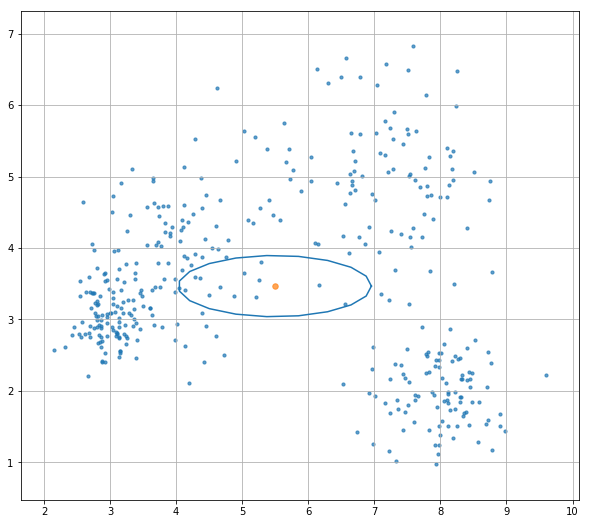

In [9]:
# рисуем начальное состояние
plt.gcf().set_size_inches(10,9)
plt.xlim(plot_frame[:,0])
plt.ylim(plot_frame[:,1])

plt.scatter( X[:,0], X[:,1],s=10,alpha=0.7)
plot_mix(S,mu,b=5.0)
plt.grid()
plt.show()

## оптимизация параметров

In [10]:
# фунция n-мерной нормальной плотности распределения
def dens_gauss(X,iS,dS,mu):
    n = X.shape[1] # размерность пространства
    s = 1.0 / np.sqrt( dS * np.square(2.0*np.pi)  )
    xm = X - mu
    return s*np.exp( -0.5 * (xm.dot(iS)*xm).sum(axis=1) )
    

In [11]:
# оценка параметров
def e_step( X, S, mu, w ):
    n_comp = len(w)
    
    m = X.shape[0] # количество учебных примеров
   
    # для для каждой компоненты смеси вычисляем ...
    # обратные матрицы ковариаций признаков 
    iS = [ np.linalg.inv(si)  for si in S ] 
    # определители матрицы ковариаций признаков 
    dS = [ np.linalg.det(si)  for si in S ] 
    
    # взвешеное значение плотности распределения для каждой точки по всем компоненитам смеси
    p = np.vstack([ dens_gauss(X,iS[j],dS[j],mu[j]) * w[j] for j in range(n_comp)] )
    
    return p/p.sum(axis=0)


In [12]:
# оптимизация параметров
def m_step(X,g,G_FACTOR=1.0):
    n_comp = g.shape[0]
    
    sg = g.sum(axis=1)
    
    w = sg/X.shape[0]   # веса компонент смеси
    
    # мат.ожидания для компонент смеси
    mu = [ ( g[j,:].reshape(X.shape[0],1) * X ).sum(axis=0) / sg[j] for j in range(n_comp) ]

    # изменяем матрицы ковариаций 
    xm = [ ( X-mu[j] ) * g[j].reshape(X.shape[0],1) for j in range(n_comp) ]
    S = [ xm[j].T.dot(xm[j]) / ( sg[j]*G_FACTOR ) for j in range(n_comp)  ]   
    
    return S, mu, w
    

In [13]:
# MAX_ITER = 100 # максимальное количество циклов
# G_MAX = 1e-3 # минимальное изменение оценки (критерий остановки EM)

def em_base(X,S,w,mu,MAX_ITER=100,G_MAX=1e-3):
    n_comp = len(w)
    # начальные значения оценок
    g = np.zeros( [ n_comp, X.shape[0],  ]  ) 

    for i in range(MAX_ITER):
        g0 = g # сохраняем старую оценку параметров
        g = e_step(X,S,mu,w) # оценка параметров
        S, mu, w = m_step(X,g) # оптимизация параметров

        # считаем изменение оценки
        gm = np.abs( g - g0 ).max() 

        assert ~np.isnan(gm), 'ошибка вычислений, неудачные начальные параметры'

        # print("%i: %f/%f"%(i,gm,G_MAX))

        #  проверяем условия завершения работы
        if( gm < G_MAX ): break # изменение оценки ниже порога, конец работы
        
    return S,w.tolist(),mu

In [14]:
def dens_mix(X,S,mu,w):
    # обратные матрицы ковариаций признаков 
    iS = [ np.linalg.inv(si)  for si in S ] 
    # определители матрицы ковариаций признаков 
    dS = [ np.linalg.det(si)  for si in S ] 
    # значение плотности для каждой точки набора
    p = np.vstack([ w[i]*dens_gauss(X,iS[i],dS[i],mu[i]) for i in range(len(w)) ])
    
    return p.sum(axis=0)

---

In [15]:
MAX_COMP=5 # максимальное количество компонент
MIN_X_SIZE = X.shape[0] // 3 # минимальная длина выборки, по которой можно восстанавливать плотность
R = 0.6 #  % коэффициент правдоподобия

In [16]:
for k in range(MAX_COMP):
    print('компонент смеси:', k+1)
  
    p = dens_mix(X,S,mu,w) # значение плотности для каждой точки
    p_max = p.max() # максимальное значение плотности

    X_hight = X[ p>=p_max*R ] # точки с высоким значением правдоподобия
    X_low = X[ p<p_max*R ] # точки с низким значением правдоподобия
  
    print('точек с низким значением правдоподобия:', X_low.shape[0] )
   
    if X_low.shape[0] < MIN_X_SIZE:  break
    print('добавляем компоненту:', k+2)
    
    # # рисуем точки с низким правдоподобием
    # plt.gcf().set_size_inches(10,9)
    # plt.xlim(plot_frame[:,0])
    # plt.ylim(plot_frame[:,1])
    # plt.scatter( X_low[:,0], X_low[:,1],s=10,alpha=0.7,c='b')
    # plt.scatter( X_hight[:,0], X_hight[:,1],s=10,alpha=0.7,c='r')
    # plt.grid()
    # plt.show()

    S_old,w_old,mu_old = S,w,mu # сохраняем старое состояние

    # добавляем компоненту смеси
    S.append( np.cov(X_low.T) ) # матрица ковариаций признаков
    
    w_l = X_low.shape[0]/X.shape[0]  # вес
    w = [ wi*(1.0-w_l) for wi in w ]
    w.append( w_l )
  
    mu.append( np.mean(X_low,axis=0)*w_l ) # мат.ожидание
 
    S,w,mu = em_base(X,S,w,mu)

    R *= R #  % коэффициент правдоподобия

компонент смеси: 1
точек с низким значением правдоподобия: 310
добавляем компоненту: 2
компонент смеси: 2
точек с низким значением правдоподобия: 180
добавляем компоненту: 3
компонент смеси: 3
точек с низким значением правдоподобия: 296
добавляем компоненту: 4
компонент смеси: 4
точек с низким значением правдоподобия: 32


## рисуем результат

In [17]:
# для для каждой компоненты смеси вычисляем ...

# обратные матрицы ковариаций признаков 
iS = [ np.linalg.inv(si)  for si in S ] 
# определители матрицы ковариаций признаков 
dS = [ np.linalg.det(si)  for si in S ] 
# значение плотности для каждой точки набора
p = np.vstack([ dens_gauss(X,iS[i],dS[i],mu[i]) for i in range(len(w)) ])

# номера компонент с максимальным значением плотности для каждой точки набора
pc = np.argmax(p,axis=0)

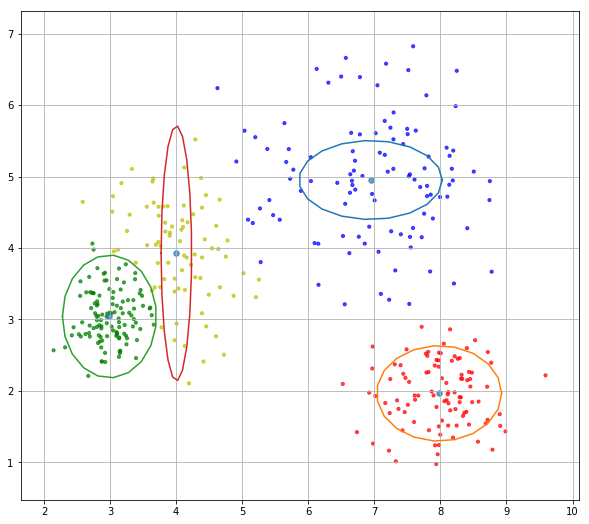

In [18]:
plt.gcf().set_size_inches(10,9)
plt.xlim(plot_frame[:,0])
plt.ylim(plot_frame[:,1])
c = [ ['b','r','g','y'][j] for j in pc  ]
plt.scatter( X[:,0], X[:,1],s=10,alpha=0.7,c=c)
plot_mix(S,mu,b=5.0)
plt.grid()
plt.show()